In [1]:
# %matplotlib widget
import numpy as np, xarray as xr, numexpr as ne, matplotlib.pyplot as plt


dataset = xr.Dataset()
dataset = dataset.assign_coords(t=np.linspace(0,100*np.pi, 2000))
dataset["fs"] = xr.apply_ufunc(lambda t: 1/(t[1]-t[0]), dataset["t"], input_core_dims=[["t"]])
dataset = dataset.assign_coords(s1=["where(t< 150,cos(t),cos(2*t))", "cos(t+pi/2)"]*1, s2= ["cos(t)", "cos(t+pi/2)", "cos(t+pi/3)"]*1)

dataset["signal_1"] = xr.apply_ufunc(lambda expr, t: ne.evaluate(expr, dict(t=t, pi=np.pi))
    , dataset["s1"], dataset["t"], input_core_dims=[[], ["t"]], output_core_dims=["t"], vectorize=True)
dataset["signal_2"] = xr.apply_ufunc(lambda expr, t: ne.evaluate(expr, dict(t=t, pi=np.pi))
    , dataset["s2"], dataset["t"], input_core_dims=[[], ["t"]], output_core_dims=["t"], vectorize=True)

dataset["s1"] = dataset["s1"].str.replace("where", "if").str.replace("*", "", regex=False)

In [2]:
#Optional: demonstrates that we can add dimensions without impact
class noisetransform:
    def __init__(self, noise=0):
        self.noise = noise
    def __repr__(self):
        return f"transform(noise={self.noise})"
    def transform(self, x):
        return x+ self.noise*np.random.rand(x.size)
    
dataset=dataset.assign_coords(noisetransformation=[noisetransform(), noisetransform(noise=3)])
for s in ["signal_1", "signal_2"]:
    dataset[s] = xr.apply_ufunc(lambda sig, t: t.transform(sig), dataset[s], dataset["noisetransformation"], input_core_dims=[["t"], []], output_core_dims= [["t"]], vectorize=True)

dataset["noisetransformation"] = dataset["noisetransformation"].astype(str)
dataset = dataset.isel(noisetransformation=[1]) #There is an impact on plotting though...
#EndOptional 

In [3]:

dataset = dataset.assign_coords(dt=np.linspace(-10*np.pi, 10*np.pi, 500))
dataset["dt_fs"] = xr.apply_ufunc(lambda t: 1/(t[1]-t[0]), dataset["dt"], input_core_dims=[["dt"]])
dataset = dataset.assign_coords(t_corr=np.linspace(0*np.pi, 100*np.pi, 100))

def correlate(s1, s2, t, bef, after, dt):
    t, bef, after, dt = int(t), int(bef), int(after), int(dt)

    if t-bef < 0 or t-bef + dt<0 or t+after >= s1.size or t+dt+after >= s2.size:
        return np.nan
    return (s1[t-bef: t+after] * s2[t+dt-bef: t+dt+after]).sum()

dataset["correlate"]= xr.apply_ufunc(correlate, dataset["signal_1"], dataset["signal_2"], 
    dataset["t_corr"]*dataset["fs"], 5*np.pi*dataset["fs"], 5*np.pi*dataset["fs"], dataset["dt"]*dataset["fs"],
    input_core_dims=[["t"]]*2+[[]]*4, vectorize=True
)

In [4]:
for i in range(1):
    dataset["fftfreq"] = xr.apply_ufunc(lambda dt_fs: np.fft.rfftfreq(dataset.sizes["dt"], d = 1/dt_fs), dataset["dt_fs"], output_core_dims=[["fftfreq"]])
    dataset["fft"] = xr.apply_ufunc(lambda a: np.fft.rfft(a, axis=-1), dataset["correlate"], input_core_dims=[["dt"]], output_core_dims=[["fftfreq"]], vectorize=False)

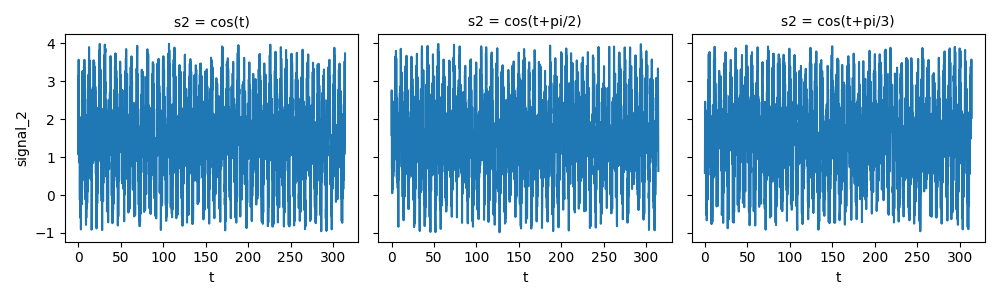

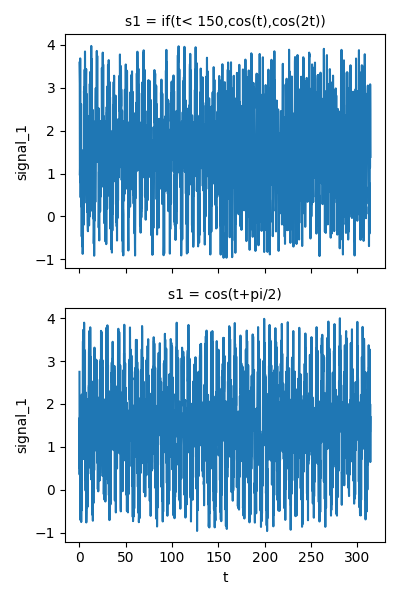

In [5]:
dataset["signal_1"].plot(row="s1")
dataset["signal_2"].plot(col="s2")
plt.show()

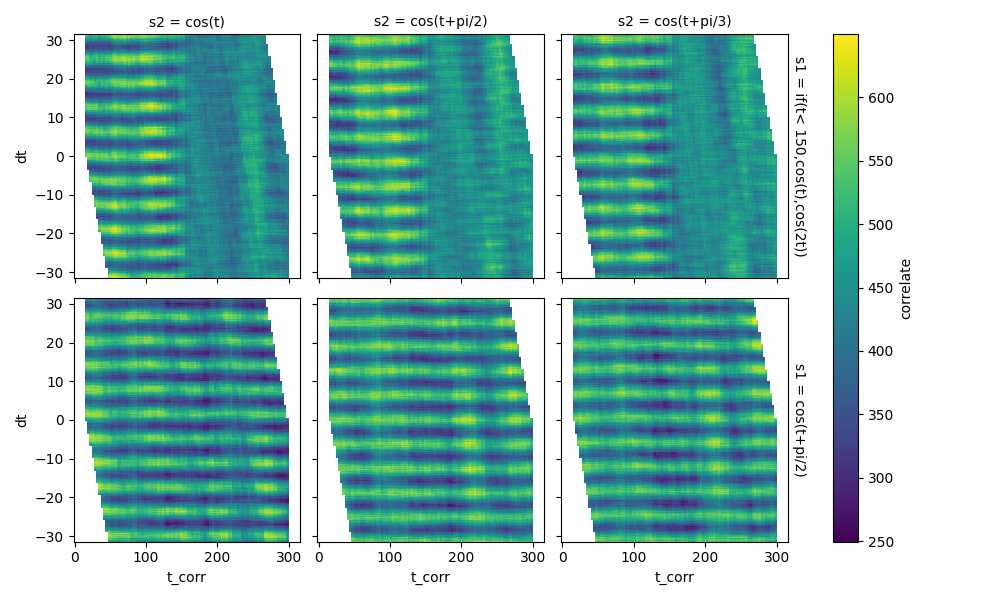

In [6]:
dataset["correlate"].plot(row="s1", col="s2", x="t_corr")
plt.show()

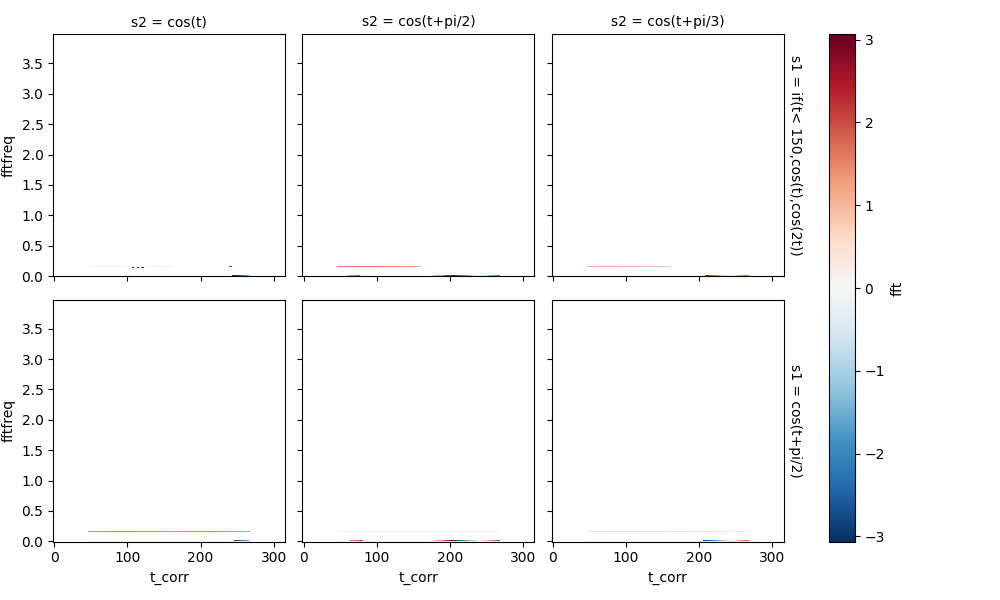

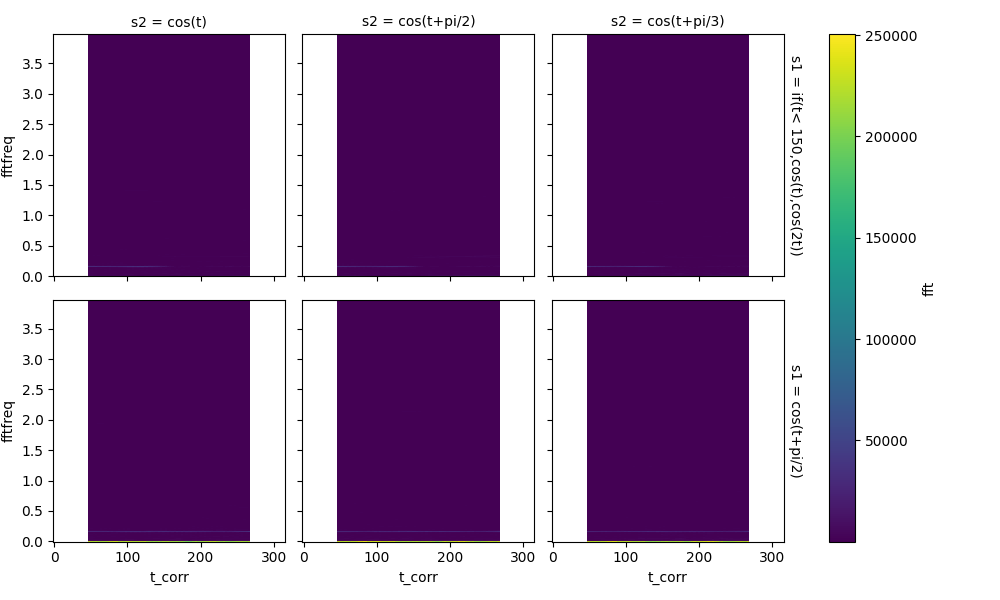

In [7]:
np.abs(dataset["fft"]).plot(row="s1", col="s2", x="t_corr")
xr.apply_ufunc(np.angle, dataset["fft"]).where(np.abs(dataset["fft"]) > 5000).plot(row="s1", col="s2", x="t_corr")
plt.show()